In [ ]:
import gym
import random
import time
import numpy as np
from collections import deque
import gym
from gym import spaces
import cv2
import random
from collections import deque
import tensorflow as tf 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,TimeDistributed,LSTM,Conv2D, MaxPooling2D,Conv3D,Reshape,MaxPooling2D,ConvLSTM2D
from tensorflow.keras.optimizers import SGD , Adam
import matplotlib.pyplot as plt
import os
import pickle
import json
from tqdm import tqdm
cv2.ocl.setUseOpenCL(False)

In [ ]:
from google.colab import drive
drive.mount("/content/myDrive2")

KeyboardInterrupt: ignored

In [ ]:
! cd /content/myDrive2/

In [ ]:
! mkdir res2

In [ ]:
cd res2

/content/res2


In [ ]:
!mkdir snaps


In [ ]:
######## CONSTANTS ########
TRAIN_STEPS = 400000
NUM_ACTIONS = 2
LR = 0.0001
GAMMA = 0.99

# evaluation trials
TRIALS = 10
######## CONSTANTS ########

In [ ]:
class ProcessFrame84(gym.ObservationWrapper):
    def __init__(self, env=None):
        super(ProcessFrame84, self).__init__(env)
        self.observation_space = spaces.Box(low=0, high=255, shape=(84, 84, 1), dtype=np.uint8)

    def observation(self, obs):
        return ProcessFrame84.process(obs)

    @staticmethod
    def process(frame):
        if frame.size == 210 * 160 * 3:
            img = np.reshape(frame, [210, 160, 3]).astype(np.float32)
        elif frame.size == 250 * 160 * 3:
            img = np.reshape(frame, [250, 160, 3]).astype(np.float32)
        else:
            assert False, "Unknown resolution."
        img = img[:, :, 0] * 0.299 + img[:, :, 1] * 0.587 + img[:, :, 2] * 0.114
        resized_screen = cv2.resize(img, (42, 55), interpolation=cv2.INTER_AREA)
        x_t = resized_screen[8:50, :]
        x_t = np.reshape(x_t, [42, 42, 1])
        return x_t.astype(np.uint8)

class ClippedRewardsWrapper(gym.RewardWrapper):
    def reward(self, reward):
        """Change all the positive rewards to 1, negative to -1 and keep zero."""
        return np.sign(reward)

class NoopResetEnv(gym.Wrapper):
    def __init__(self, env, noop_max=30):
        """Sample initial states by taking random number of no-ops on reset.
        No-op is assumed to be action 0.
        """
        gym.Wrapper.__init__(self, env)
        self.noop_max = noop_max
        self.override_num_noops = None
        self.noop_action = 0
        assert env.unwrapped.get_action_meanings()[0] == 'NOOP'

    def reset(self, **kwargs):
        """ Do no-op action for a number of steps in [1, noop_max]."""
        self.env.reset(**kwargs)
        if self.override_num_noops is not None:
            noops = self.override_num_noops
        else:
            noops = self.unwrapped.np_random.randint(1, self.noop_max + 1) #pylint: disable=E1101
        assert noops > 0
        obs = None
        for _ in range(noops):
            obs, _, done, _ = self.env.step(self.noop_action)
            if done:
                obs = self.env.reset(**kwargs)
        return obs

    def step(self, ac):
        return self.env.step(ac)

class FireResetEnv(gym.Wrapper):
    def __init__(self, env):
        """Take action on reset for environments that are fixed until firing."""
        gym.Wrapper.__init__(self, env)
        assert env.unwrapped.get_action_meanings()[1] == 'FIRE'
        assert len(env.unwrapped.get_action_meanings()) >= 3

    def reset(self, **kwargs):
        self.env.reset(**kwargs)
        obs, _, done, _ = self.env.step(1)
        if done:
            self.env.reset(**kwargs)
        obs, _, done, _ = self.env.step(2)
        if done:
            self.env.reset(**kwargs)
        return obs

    def step(self, ac):
        return self.env.step(ac)

class EpisodicLifeEnv(gym.Wrapper):
    def __init__(self, env):
        """Make end-of-life == end-of-episode, but only reset on true game over.
        Done by DeepMind for the DQN and co. since it helps value estimation.
        """
        gym.Wrapper.__init__(self, env)
        self.lives = 0
        self.was_real_done  = True

    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        self.was_real_done = done
        # check current lives, make loss of life terminal,
        # then update lives to handle bonus lives
        lives = self.env.unwrapped.ale.lives()
        if lives < self.lives and lives > 0:
            # for Qbert sometimes we stay in lives == 0 condtion for a few frames
            # so its important to keep lives > 0, so that we only reset once
            # the environment advertises done.
            done = True
        self.lives = lives
        return obs, reward, done, info

    def reset(self, **kwargs):
        """Reset only when lives are exhausted.
        This way all states are still reachable even though lives are episodic,
        and the learner need not know about any of this behind-the-scenes.
        """
        if self.was_real_done:
            obs = self.env.reset(**kwargs)
        else:
            # no-op step to advance from terminal/lost life state
            obs, _, _, _ = self.env.step(0)
        self.lives = self.env.unwrapped.ale.lives()
        return obs

class MaxAndSkipEnv(gym.Wrapper):
    def __init__(self, env, skip=4):
        """Return only every `skip`-th frame"""
        gym.Wrapper.__init__(self, env)
        # most recent raw observations (for max pooling across time steps)
        self._obs_buffer = np.zeros((2,)+env.observation_space.shape, dtype=np.uint8)
        self._skip       = skip

    def step(self, action):
        """Repeat action, sum reward, and max over last observations."""
        total_reward = 0.0
        done = None
        for i in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            if i == self._skip - 2: self._obs_buffer[0] = obs
            if i == self._skip - 1: self._obs_buffer[1] = obs
            total_reward += reward
            if done:
                break
        # Note that the observation on the done=True frame
        # doesn't matter
        max_frame = self._obs_buffer.max(axis=0)

        return max_frame, total_reward, done, info

    def reset(self, **kwargs):
        return self.env.reset(**kwargs)

class ClipRewardEnv(gym.RewardWrapper):
    def __init__(self, env):
        gym.RewardWrapper.__init__(self, env)

    def reward(self, reward):
        """Bin reward to {+1, 0, -1} by its sign."""
        return np.sign(reward)

class WarpFrame(gym.ObservationWrapper):
    def __init__(self, env, width=84, height=84, grayscale=True):
        """Warp frames to 84x84 as done in the Nature paper and later work."""
        gym.ObservationWrapper.__init__(self, env)
        self.width = width
        self.height = height
        self.grayscale = grayscale
        if self.grayscale:
            self.observation_space = spaces.Box(low=0, high=255,
                shape=(self.height, self.width, 1), dtype=np.uint8)
        else:
            self.observation_space = spaces.Box(low=0, high=255,
                shape=(self.height, self.width, 3), dtype=np.uint8)

    def observation(self, frame):
        if self.grayscale:
            frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        frame = cv2.resize(frame, (self.width, self.height), interpolation=cv2.INTER_AREA)
        if self.grayscale:
            frame = np.expand_dims(frame, -1)
        return frame

class FrameStack(gym.Wrapper):
    def __init__(self, env, k):
        """Stack k last frames.
        Returns lazy array, which is much more memory efficient.
        See Also
        --------
        baselines.common.atari_wrappers.LazyFrames
        """
        gym.Wrapper.__init__(self, env)
        self.k = k
        self.frames = deque([], maxlen=k)
        shp = env.observation_space.shape
        self.observation_space = spaces.Box(low=0, high=255, shape=(shp[:-1] + (shp[-1] * k,)), dtype=env.observation_space.dtype)

    def reset(self):
        ob = self.env.reset()
        for _ in range(self.k):
            self.frames.append(ob)
        return self._get_ob()

    def step(self, action):
        ob, reward, done, info = self.env.step(action)
        self.frames.append(ob)
        return self._get_ob(), reward, done, info

    def _get_ob(self):
        assert len(self.frames) == self.k
        return list(self.frames)

class ScaledFloatFrame(gym.ObservationWrapper):
    def __init__(self, env):
        gym.ObservationWrapper.__init__(self, env)
        self.observation_space = gym.spaces.Box(low=0, high=1, shape=env.observation_space.shape, dtype=np.float32)

    def observation(self, observation):
        # careful! This undoes the memory optimization, use
        # with smaller replay buffers only.
        return np.array(observation).astype(np.float32) / 255.0

class LazyFrames(object):
    def __init__(self, frames):
        """This object ensures that common frames between the observations are only stored once.
        It exists purely to optimize memory usage which can be huge for DQN's 1M frames replay
        buffers.
        This object should only be converted to numpy array before being passed to the model.
        You'd not believe how complex the previous solution was."""
        self._frames = frames
        self._out = None

    def _force(self):
        if self._out is None:
            self._out = np.concatenate(self._frames, axis=-1)
            self._frames = None
        return self._out

    def __array__(self, dtype=None):
        out = self._force()
        if dtype is not None:
            out = out.astype(dtype)
        return out

    def __len__(self):
        return len(self._force())

    def __getitem__(self, i):
        return self._force()[i]

def make_atari(env_id, timelimit=True):
    # XXX(john): remove timelimit argument after gym is upgraded to allow double wrapping
    env = gym.make(env_id)
    if not timelimit:
        env = env.env
    assert 'NoFrameskip' in env.spec.id
    env = NoopResetEnv(env, noop_max=30)
    env = MaxAndSkipEnv(env, skip=4)
    return env

def wrap_deepmind(env, episode_life=True, clip_rewards=True, frame_stack=False, scale=False):
    """Configure environment for DeepMind-style Atari.
    """
    if episode_life:
        env = EpisodicLifeEnv(env)
    if 'FIRE' in env.unwrapped.get_action_meanings():
        env = FireResetEnv(env)
    env = WarpFrame(env)
    if scale:
        env = ScaledFloatFrame(env)
    if clip_rewards:
        env = ClipRewardEnv(env)
    if frame_stack:
        env = FrameStack(env, 4)
    return env

In [ ]:
def wrap_dqn(env):
    """Apply a common set of wrappers for Atari games."""
    assert 'NoFrameskip' in env.spec.id
    env = EpisodicLifeEnv(env)
    env = NoopResetEnv(env, noop_max=30)
    env = MaxAndSkipEnv(env, skip=4)
    if 'FIRE' in env.unwrapped.get_action_meanings():
        env = FireResetEnv(env)
    
    env = ProcessFrame84(env)
    env = FrameStack(env, 4)
    env = ClippedRewardsWrapper(env)
    return env

env = wrap_dqn(gym.make('PongNoFrameskip-v4'))

In [ ]:
state=env.reset()
print(np.array(state).shape)
input_shape=(4,42,42,1)
np.array(state).shape

(4, 42, 42, 1)


(4, 42, 42, 1)

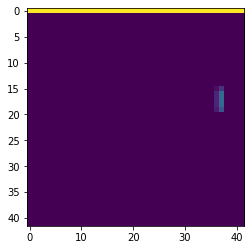

In [ ]:
plt.imshow(np.array(state[0]).reshape(42,42))

In [ ]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

class DQNAgent:
	'''
	Deep Q-Networks Agent
	'''
	def __init__(self,
          env,
          num_actions,
          lr,
          discount,
          batch_size=32,
          mem_size=100000,
          prefetch_size=10000,
          eps=0.7,
          eps_decay=0.99,
          eps_min=0.02):
          '''
          Agent Initialization

          :param env: OpenAI gym environment
          :param lr: Learning rate (a.k.a alpha)
          :param num_actions: number of available actions
          :param discount: Discount factor (a.k.a gamma)
          :param batch_size: batch size for training
          :param mem_size: experience replay buffer size
          :param prefetch_size: size of buffer before training starts
          :param eps: epsilon (exploration vs exploitation)
          :param eps_decay: epsilon decay rate
          :param eps_min: minimum possible value of epsilon
          '''
          self.env = env
          self.n_actions = num_actions
          state = self.env.reset()
          self.state_shape = self.preprocess(state).shape
          print ("state shape:",self.state_shape)
          self.discount = discount

          # epsilon
          self.eps = eps
          self.eps_decay_rate = eps_decay
          self.eps_min = eps_min

          # training parameters
          self.lr = lr
          self.batch_size = batch_size
          self.prefetch_size = prefetch_size

          # memory
          self.mem_size = mem_size
          self.mem = deque(maxlen=self.mem_size)
          
          # network		
          self.model = self._build_model()
              
          #score
          self.score=[]

	def _build_model(self):
          '''
          Build the network using keras
          '''
          model = Sequential()
          model.add(ConvLSTM2D(32,kernel_size=(8,8),strides=(4,4),padding="same",input_shape=(4,42,42,1)))   
          model.add(ConvLSTM2D(32,kernel_size=(8,8),strides=(4,4),padding="same",input_shape=(4,42,42,1))) 
          model.add(ConvLSTM2D(32,kernel_size=(8,8),strides=(4,4),padding="same",input_shape=(4,42,42,1)))        
          model.add((Dense(32,activation="relu")))
          model.add(Dense(self.n_actions))  
          adam = Adam(lr=self.lr)
          model.compile(loss='mse',optimizer=adam)			
            
          return model
        
	def preprocess(self,state):
          return np.array(state).reshape((1,4,42,42,1))
          
	def act(self,state,random_en=False):
          '''
          Return best action based on current Q-states

          :param state: current state
          :param random_en: enable random actions?
          :returns: Chosen action number
          '''
          if len(state) == 4:
            state = self.preprocess(state)

          if random_en:
            eps = self.eps
          else:
            eps = 0

          if random.random() <= eps:
            return random.randrange(self.n_actions) +2
          else:
            Qs = self.model.predict(state)[0]
            return np.argmax(softmax(Qs)) +2
        
	def remember(self,state, action, reward, next_state, done):
          '''
          Save to experience replay buffer
          '''
          self.mem.append((state, action, reward, next_state, done))

	def replay(self,history,n):
          '''
          Main experience replay routine
          '''
          
          minibatch = random.sample(self.mem, self.batch_size)
          states = []
          targets = []
          for state, action, reward, next_state, done in minibatch:
            Q = reward
            if not done:
              next_Qs = self.model.predict(next_state)
              Q = reward + self.discount*np.amax(next_Qs)
            target_Qs = self.model.predict(state)
            target_Qs[0][action-2] = Q
            states.append(state)
            targets.append(target_Qs[0])
          history[n]=self.model.fit(np.stack(states,axis=0).reshape((32,3,42,42,1)),np.stack(targets,axis=0),epochs=1,verbose=0)

	
	def train(self,timesteps,weights_file=None,save_step=10000):
          '''
          Train agent

          :param timesteps: timesteps to train agent with
          :param weights_file: file path to save trained weights
          :param save_step: when to save model
          '''
          n=0
          history=dict()
          state = self.env.reset()
          state = self.preprocess(state)
          target_reward=0
          i=0
          for t in tqdm(range(1,timesteps+1)):
                  
            action = self.act(state,random_en=True)
            
            # epsilon decay
            if t % 1000 == 0:
              self.eps = max(self.eps_min,self.eps*self.eps_decay_rate)
                  

            next_state,reward,done,_ = self.env.step(action)
            next_state = self.preprocess(next_state)
            self.remember(state, action, reward, next_state, done)
            state = next_state
            target_reward+=reward

            # check if buffer is filled enough to do replay
            if len(self.mem) > self.prefetch_size:
              self.replay(history,n)

            # reset environment if reached terminal state
            if done:
                      
              self.score.append(target_reward)
              print(print("episode: {}/{}, score: {}".format(t, 400000, target_reward))) 
              target_reward=0
              state = self.env.reset()
              state = self.preprocess(state)          
            # save model
            if t % save_step == 0 and weights_file is not None:
              n=n+1
              i=i+1                
              self.save_model(weights_file+format(i+4))              


	def load_model(self,weights_file):
            '''
            Load model weights
            :param weights_file: weights file paths
            '''
            self.model.load_weights(weights_file+".h5")
            print ('Model loaded ...')

	def save_model(self,weights_file):
            '''
            Save model weights
            :param weights_file: weights file paths
            '''
            self.model.save_weights(weights_file+".h5", overwrite=True)
            with open(weights_file+".json", "w") as outfile:
              json.dump(self.model.to_json(), outfile)
            print('Model saved ...')

In [ ]:
agent = DQNAgent(env=env,num_actions=NUM_ACTIONS,lr=LR,discount=GAMMA)
agent.model.summary()

state shape: (1, 3, 42, 42, 1)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 3, 11, 11, 32)     2080      
_________________________________________________________________
time_distributed_1 (TimeDist (None, 3, 11, 11, 32)     0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 3, 6, 6, 64)       32832     
_________________________________________________________________
time_distributed_3 (TimeDist (None, 3, 6, 6, 64)       0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 3, 6, 6, 64)       36928     
_________________________________________________________________
time_distributed_5 (TimeDist (None, 3, 6, 6, 64)       0         
_________________________________________________________________
time_distributed_6 (TimeD

In [ ]:
agent.train(TRAIN_STEPS,weights_file="snaps/model")

  0%|          | 757/400000 [00:12<1:07:17, 98.88it/s]

episode: 739/400000, score: -21.0
None


  0%|          | 1531/400000 [00:18<53:29, 124.17it/s]

episode: 1499/400000, score: -21.0
None


  1%|          | 2274/400000 [00:24<51:39, 128.32it/s]

episode: 2260/400000, score: -21.0
None


  1%|          | 3039/400000 [00:30<48:22, 136.79it/s]

episode: 3021/400000, score: -21.0
None


  1%|          | 3782/400000 [00:37<1:01:32, 107.31it/s]

episode: 3778/400000, score: -21.0
None


  1%|          | 4553/400000 [00:43<52:04, 126.58it/s]

episode: 4533/400000, score: -21.0
None


  1%|▏         | 5311/400000 [00:50<1:02:08, 105.85it/s]

episode: 5294/400000, score: -21.0
None


  2%|▏         | 6069/400000 [00:56<1:03:31, 103.35it/s]

episode: 6050/400000, score: -21.0
None


  2%|▏         | 6813/400000 [01:03<57:57, 113.06it/s]  

episode: 6807/400000, score: -21.0
None


  2%|▏         | 7581/400000 [01:11<1:05:12, 100.30it/s]

episode: 7567/400000, score: -21.0
None


  2%|▏         | 8337/400000 [01:18<1:23:36, 78.07it/s]

episode: 8329/400000, score: -21.0
None


  2%|▏         | 9103/400000 [01:25<54:33, 119.40it/s]

episode: 9090/400000, score: -21.0
None


  2%|▏         | 9859/400000 [01:32<52:46, 123.20it/s]

episode: 9847/400000, score: -21.0
None


  2%|▏         | 9992/400000 [01:33<1:01:58, 104.87it/s]

Model saved ...


  3%|▎         | 10662/400000 [16:54<147:30:09,  1.36s/it]

episode: 10662/400000, score: -21.0
None


  3%|▎         | 12142/400000 [51:26<147:44:15,  1.37s/it]

episode: 12142/400000, score: -16.0
None


  3%|▎         | 12718/400000 [1:04:48<144:56:48,  1.35s/it]

In [ ]:
import tensorflow as tf 

In [ ]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))